## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle as ls
import lightkurve as lk
from astropy.io import fits


from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants as c
from scipy import stats

import pymc as pm
import pymc_ext as pmx
import arviz as az
from celerite2.pymc import GaussianProcess, terms
import pytensor.tensor as pt
%matplotlib inline

In [2]:
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

mpl.rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
mpl.rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
mpl.rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

## System parameters

In [3]:
# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480
TIC_ID = 22233480
epoch_tess = ufloat(2459396.409578, 0.00075457105)
period_tess = ufloat(7.4463033768041, 0.000023020093)
depth_tess = ufloat(4045.7241784744, 128.28719)
duration_tess = ufloat(2.0033137761697, 0.15890975)
radius_tess = ufloat(2.4048644350425, 0.3086393)
insolation_tess = 5.6286113934149
stmass_tess = ufloat(0.363996, 0.0201927)
strad_tess = ufloat(0.375859, 0.0111301)


## Read RVs

In [4]:
spirou = pd.read_table('./data/toi4438/lbl2_TOI4438_GL699_jun24.rdb', sep=None, engine='python', header=0)
carmenes = pd.read_table('./data/toi4438/carmenes_data/carmenes.rdb', sep=None, engine='python', header=0)

# substract 2400000 to the BJD time of carmenes
carmenes['rjd'] = carmenes['rjd'] - 2400000
rv_inst_names = ['spirou', 'carmenes']

star_name = 'TOI 4438'

In [5]:
spirou.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Columns: 172 entries, rjd to svrad_2449nm
dtypes: float64(159), object(13)
memory usage: 87.5+ KB


In [6]:
# d2v is "differential line width", an activity indicator. 
# d3v is then the column linked to the third derivative, it is supposed to be linked to the asymmetry of the line, 
# but as far as I know no one tries to use that product yet
spirou.head()

,rjd,vrad,svrad,d2v,sd2v,d3v,sd3v,local_file_name,plot_date,dW,...,vrad_2080nm,svrad_2080nm,vrad_2167nm,svrad_2167nm,vrad_2257nm,svrad_2257nm,vrad_2351nm,svrad_2351nm,vrad_2449nm,svrad_2449nm
0,59732.984348,-35123.282863,2.684813,1.043918e+06,6328.720826,2.403151e+07,1.088609e+07,2762023o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19145.475297,5.788712e+06,...,-35139.276131,7.601464,-35142.848891,12.843047,-35278.706195,19.611777,-35104.821769,15.491543,-35116.558072,20.264451
1,59734.020205,-35115.826332,2.745238,1.069501e+06,6457.594639,1.359737e+07,1.114657e+07,2762205o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19146.511146,5.930571e+06,...,-35121.989859,7.376265,-35132.543544,12.007437,-35199.380784,19.582315,-35078.673786,16.539267,-35143.804930,23.803596
2,59735.057384,-35112.464280,2.774137,1.015239e+06,6503.867083,6.135536e+06,1.125510e+07,2762381o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19147.548289,5.629680e+06,...,-35123.152654,7.596685,-35098.678961,12.524601,-35178.795053,20.275638,-35088.179654,16.662846,-35107.175059,24.196206
3,59735.989705,-35112.289597,2.964529,1.106869e+06,6888.458366,1.333161e+07,1.198604e+07,2762545o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19148.480591,6.137783e+06,...,-35125.376272,7.994345,-35094.420427,12.553439,-35177.306930,22.404775,-35086.701617,19.841099,-35091.842427,30.735095
4,59736.952200,-35111.584013,2.746853,1.065667e+06,6422.218951,1.455431e+07,1.112230e+07,2762718o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19149.443098,5.909314e+06,...,-35112.214136,7.194740,-35120.557407,11.992031,-35194.480320,19.176249,-35116.034145,15.870554,-35106.776137,22.023425


In [7]:
carmenes.head()

,rjd,vrad,svrad
0,59720.6490,1.90,3.99
1,59726.5607,-6.93,2.02
2,59730.5751,-1.11,2.20
3,59736.5664,2.74,1.81
4,59738.6403,-3.77,1.97


### Outliers

Text(0.5, 0, 'RV [km/s]')

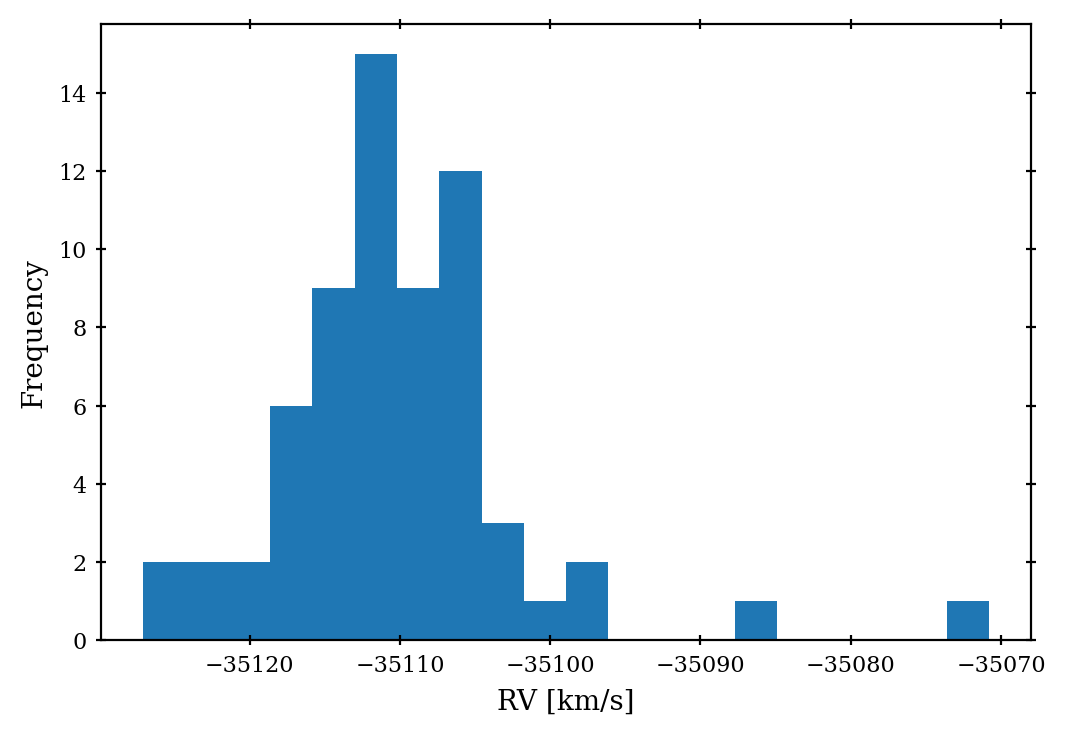

In [8]:
# histograma
spirou.vrad.plot(kind='hist', bins=20)
plt.xlabel('RV [km/s]')

<Axes: >

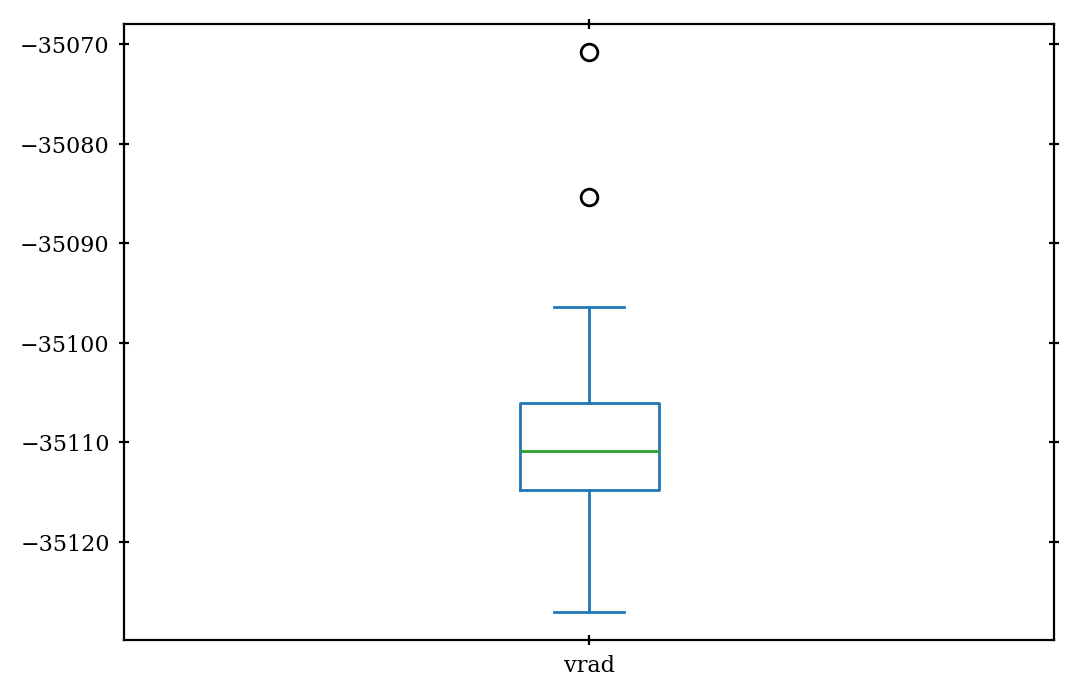

In [9]:
# boxplot
spirou.vrad.plot(kind='box')

In [10]:
# detect outliers using iqr
q1 = spirou.vrad.quantile(0.25)
q3 = spirou.vrad.quantile(0.75)
iqr = q3 - q1
mask = (spirou.vrad < (q1 - 1.5 * iqr)) | (spirou.vrad > (q3 + 1.5 * iqr))

# filter outliers
spirou = spirou[~mask]

# substract the mean of the radial velocity
spirou['vrad'] = spirou['vrad'] - spirou['vrad'].mean()

<Axes: >

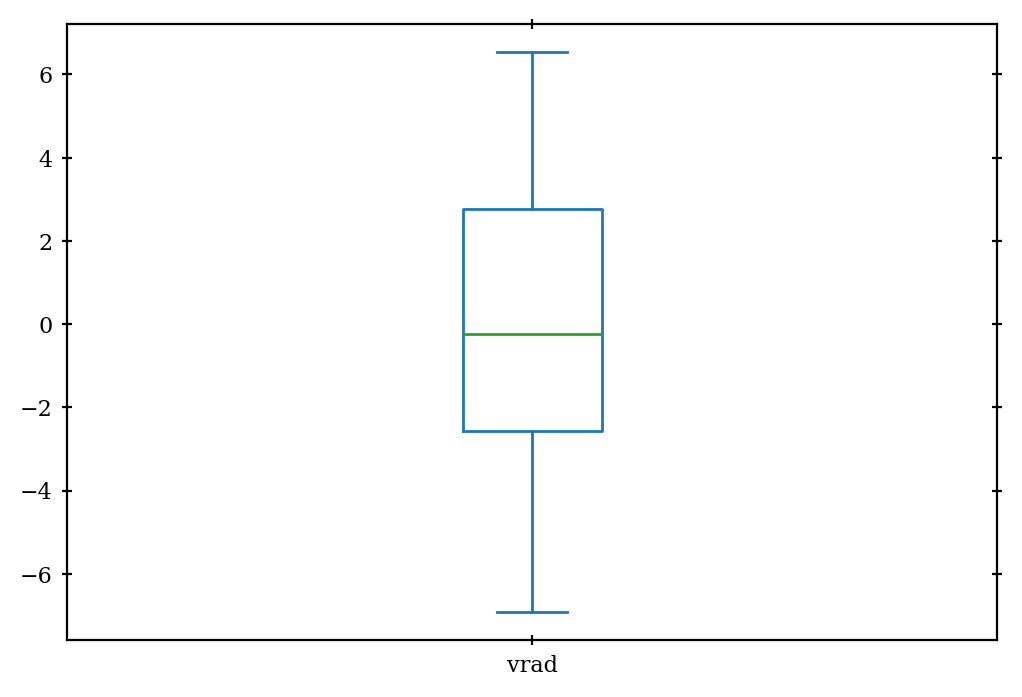

In [11]:
# after filtering
carmenes.vrad.plot(kind='box')

### Plot RVs

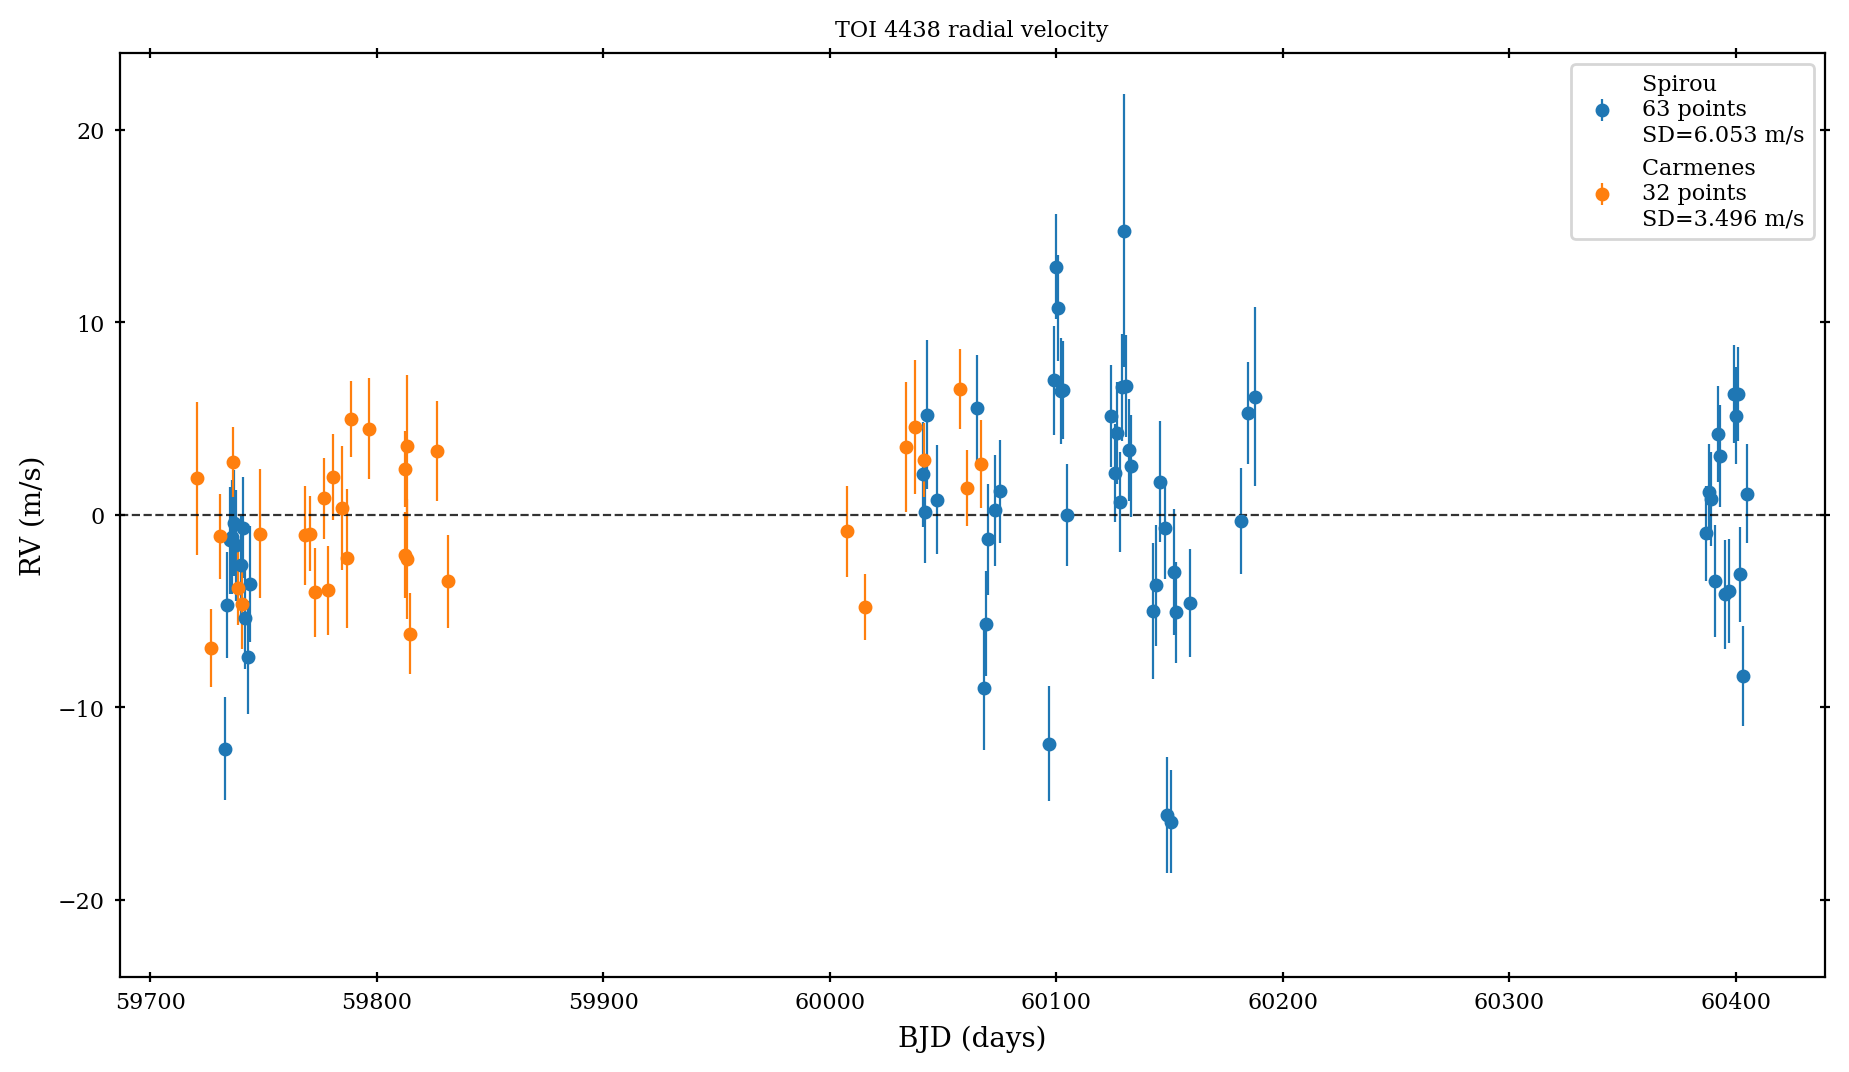

In [12]:
fig, ax = plt.subplots(figsize=(11, 6))

ax.errorbar(spirou['rjd'], spirou['vrad'], yerr=spirou['svrad'], fmt='o', label=f'Spirou \n{len(spirou)} points\nSD={np.round(np.std(spirou.vrad),3)} m/s', markersize=4, elinewidth=0.8, color='C0')
ax.errorbar(carmenes['rjd'], carmenes['vrad'], yerr=carmenes['svrad'], fmt='o', label=f'Carmenes \n{len(carmenes)} points\nSD={np.round(np.std(carmenes.vrad),3)} m/s', markersize=4, elinewidth=0.8, color='C1')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.8)
ax.legend()
ax.set_title(f'{star_name} radial velocity')
ax.set_ylim(-24, 24)
ax.set_xlabel('BJD (days)')
ax.set_ylabel('RV (m/s)')
plt.show()

In [13]:
# prepare the data for the model
x_rv = np.concatenate((spirou['rjd'], carmenes['rjd']))
y_rv = np.concatenate((spirou['vrad'], carmenes['vrad']))
yerr_rv = np.concatenate((spirou['svrad'], carmenes['svrad']))
rv_inst_id = np.concatenate((np.zeros(len(spirou)), np.ones(len(carmenes))))

inds = np.argsort(x_rv)
t_rv = np.ascontiguousarray(x_rv[inds], dtype=np.float64)
rv = np.ascontiguousarray(y_rv[inds], dtype=np.float64)
rv_err = np.ascontiguousarray(yerr_rv[inds], dtype=np.float64)
rv_inst_id = np.ascontiguousarray(rv_inst_id[inds], dtype=int)

num_rv_inst = len(rv_inst_names)

### GLS analysis

In [14]:
series = ['spirou rvs', 'spirou dlw',  'carmenes rvs', 'all rvs', 'window function']

lg = [ls(spirou.rjd, spirou.vrad, spirou.svrad),
      ls(spirou.rjd, spirou.d2v, spirou.sd2v),
      ls(carmenes.rjd, carmenes.vrad, carmenes.svrad),
      ls(t_rv, rv, rv_err),
      ls(spirou.rjd, np.ones(len(spirou.rjd)), fit_mean=False, center_data=False)]

min_freq = 0.001
max_freq = 10
sppk = 5
probabilities = [0.1, 0.05, 0.01]

freq = {}
power = {}
fap = {}

for n, name in enumerate(series):
    freq[name], power[name] = lg[n].autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=sppk)
    if name != 'window function':
        fap[name] = lg[n].false_alarm_level(probabilities)

Text(0, 0.5, 'Power')

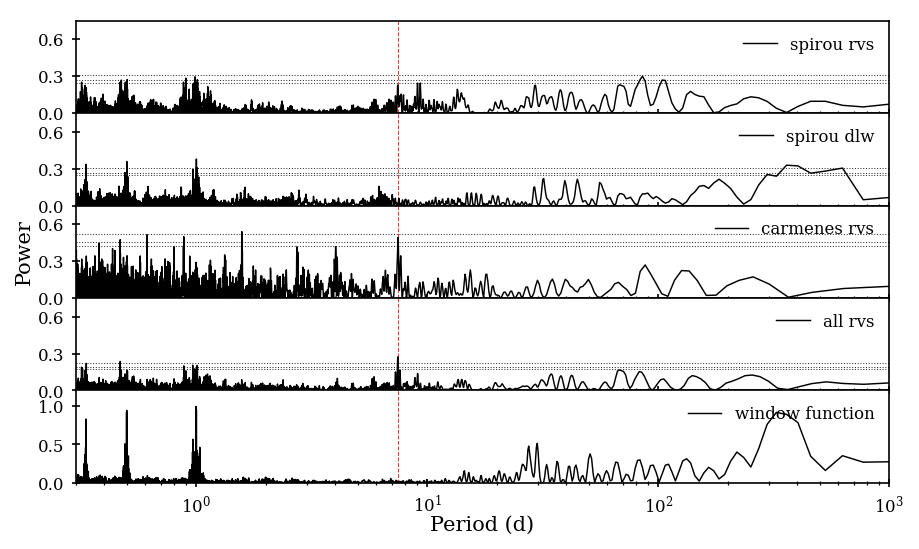

In [15]:
# plot the periodograms
fig, ax = plt.subplots(len(series), 1, sharex=True, figsize=(7,4), dpi=150)
#fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

for i, name in enumerate(series):
    ax[i].axvline(x=period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8)
    ax[i].plot(1/freq[series[i]], power[series[i]], color='k', linewidth=0.7, label=name)
    ax[i].set_ylabel(series[i])
    ax[i].set_ylim(0, 0.75)
    ax[i].set_xlim(0.3, 1000)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend(frameon=False, markerscale=0, loc='upper right')
    ax[i].set_yticks([0.0, 0.3, 0.6])
    ax[i].tick_params(which='both', top=False, right=False)
    if name == "window function":
        ax[i].set_ylim(0, 1.2)
        ax[i].set_yticks([0.0, 0.5, 1.0])
    else:
        ax[i].axhline(y=fap[name][0], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                  , label=f'FAP {probabilities[0]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][1], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[1]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][2], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[2]*100}%', zorder=0)
    
# add a big axis, hide frame
bigax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bigax.set_xlabel("Period (d)", labelpad=2)
bigax.set_ylabel("Power", labelpad=2)

## Read LCs

In [16]:
#exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480

In [17]:
tpf_search = lk.search_targetpixelfile('TIC 22233480')
tpf_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,22233480,0.0
1,TESS Sector 52,2022,SPOC,120,22233480,0.0
2,TESS Sector 53,2022,SPOC,120,22233480,0.0
3,TESS Sector 79,2024,SPOC,20,22233480,0.0
4,TESS Sector 79,2024,SPOC,120,22233480,0.0
5,TESS Sector 40,2021,TESS-SPOC,600,22233480,0.0
6,TESS Sector 52,2022,TESS-SPOC,600,22233480,0.0
7,TESS Sector 53,2022,TESS-SPOC,600,22233480,0.0


In [18]:
search = lk.search_lightcurve('TIC 22233480')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,22233480,0.0
1,TESS Sector 52,2022,SPOC,120,22233480,0.0
2,TESS Sector 53,2022,SPOC,120,22233480,0.0
3,TESS Sector 79,2024,SPOC,20,22233480,0.0
4,TESS Sector 79,2024,SPOC,120,22233480,0.0
5,TESS Sector 40,2021,TESS-SPOC,600,22233480,0.0
6,TESS Sector 52,2022,TESS-SPOC,600,22233480,0.0
7,TESS Sector 53,2022,TESS-SPOC,600,22233480,0.0
8,TESS Sector 40,2021,QLP,600,22233480,0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

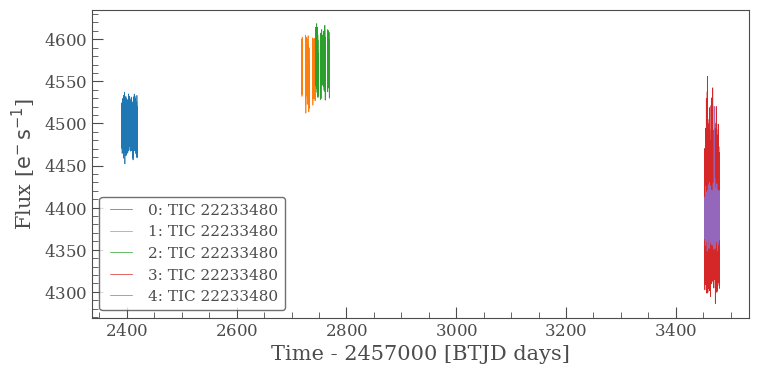

In [19]:
search[search.author == 'SPOC'].download_all().plot()

In [20]:
# save the lightcurves
lc_short_file = lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120, sector=[40, 52, 53]).download_all(flux_column="pdcsap_flux")
lc_79_fast_file = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[79], exptime=20).download_all(flux_column="pdcsap_flux")
lc_79_short_file = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[79], exptime=120).download_all(flux_column="pdcsap_flux")
lc_short_all_file = lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120, sector=[40, 52, 53, 79]).download_all(flux_column="pdcsap_flux")

In [21]:
lc_short_all = lc_short_all_file.stitch().remove_nans().normalize().remove_outliers()
lc_short = lc_short_file.stitch().remove_nans().normalize().remove_outliers()
lc_79_fast = lc_79_fast_file.stitch().remove_nans().normalize().remove_outliers()
lc_79_fast_bin = lc_79_fast.bin(time_bin_size=120*u.s.to(u.day)).remove_nans()
lc_79_short = lc_79_short_file.stitch().remove_nans().normalize().remove_outliers()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

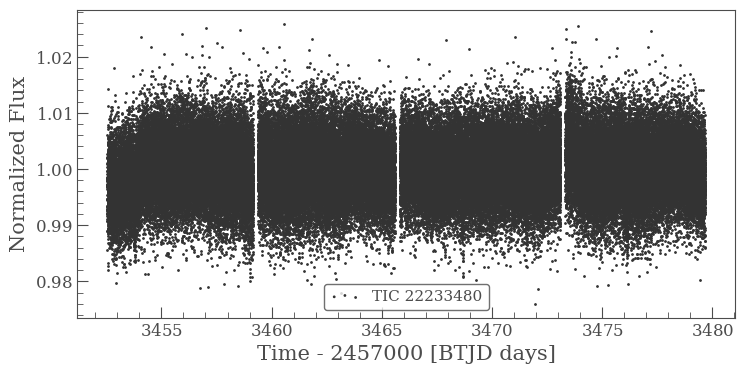

In [22]:
# plot sector 79 fast cadence
lc_79_fast.scatter()

(-0.5, 0.5)

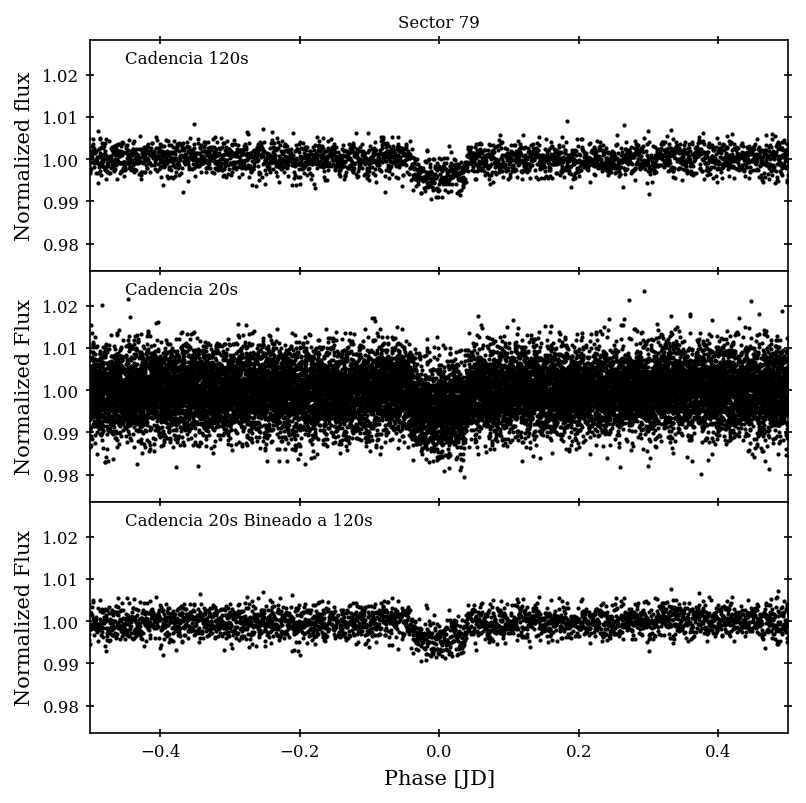

In [23]:
# sector 79
fig, ax = plt.subplots(3, 1, figsize=(6,6), dpi=150, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
lc_79_short.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[0], c='k', label='')
lc_79_fast.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[1], c='k', label='')
lc_79_fast_bin.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[2], c='k', label='')
ax[0].text(0.05, 0.9, 'Cadencia 120s', transform=ax[0].transAxes)
ax[1].text(0.05, 0.9, 'Cadencia 20s', transform=ax[1].transAxes)
ax[2].text(0.05, 0.9, 'Cadencia 20s Bineado a 120s', transform=ax[2].transAxes)
ax[0].set_title('Sector 79')
ax[0].set_ylabel('Normalized flux')
ax[0].set_xlabel('Phase')
plt.xlim(-0.5, 0.5)
#plt.savefig('lc_79.png', dpi=300)

### LC to use

In [24]:
# for the model, short and fast cadence are concatenated
time = np.concatenate((lc_short.time.value, lc_79_fast.time.value))
flux = np.concatenate((lc_short.flux.value, lc_79_fast.flux.value))
flux_err = np.concatenate((lc_short.flux_err.value, lc_79_fast.flux_err.value))
lc_cadence = np.concatenate((np.zeros(len(lc_short.time.value)), np.ones(len(lc_79_fast.time.value))))
inds2 = np.argsort(time)
time = np.ascontiguousarray(time[inds2], dtype=np.float64)
flux = np.ascontiguousarray(flux[inds2], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[inds2], dtype=np.float64)
lc_cadence = np.ascontiguousarray(lc_cadence[inds2], dtype=int)
cadences = ['120s', '20s']
num_lc_cadence = len(cadences)

# for faster computation, sector 79 binned to 120s
# only sector 79
time_fast = lc_79_fast_bin.time.value
flux_fast = lc_79_fast_bin.flux.value
flux_err_fast = lc_79_fast_bin.flux_err.value

# all sectors with 120s cadence, 79 binned from 20s
time_short = np.ascontiguousarray(np.concatenate((lc_short.time.value, lc_79_fast_bin.time.value)), dtype=np.float64)
flux_short = np.ascontiguousarray(np.concatenate((lc_short.flux.value, lc_79_fast_bin.flux.value)), dtype=np.float64)
flux_err_short = np.ascontiguousarray(np.concatenate((lc_short.flux_err.value, lc_79_fast_bin.flux_err.value)), dtype=np.float64)

# all sectors with 120s cadence
time_short_all = np.ascontiguousarray(lc_short_all.time.value, dtype=np.float64)
flux_short_all = np.ascontiguousarray(lc_short_all.flux.value, dtype=np.float64)
flux_err_short_all = np.ascontiguousarray(lc_short_all.flux_err.value, dtype=np.float64)

# get the exptimes
with fits.open(lc_short_file[0].filename) as hdu:
    hdr = hdu[1].header
with fits.open(lc_79_fast_file[0].filename) as hdu:
    hdr_79 = hdu[1].header

texp_short = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp_short /= 60.0 * 60.0 * 24.0
texp_79 = hdr_79["FRAMETIM"] * hdr_79["NUM_FRM"]
texp_79 /= 60.0 * 60.0 * 24.0

ref_time = np.min(time_short)
x = np.ascontiguousarray(time_short - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux_short - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr = np.ascontiguousarray(1e3 * flux_err_short, dtype=np.float64) 

### TLS analysis

In [25]:
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

In [26]:
# lets recover first the planet detected by TESS 
tls_time, tls_flux, tls_flux_err = cleaned_array(time_short, flux_short, flux_err_short)

# catalog_info: ab, mass, mass_min, mass_max, radius, radius_min, radius_max
info = catalog_info(TIC_ID=TIC_ID) # to put priors on search
tls = transitleastsquares(tls_time, tls_flux, tls_flux_err)
results = tls.power(R_star=float(info[4]), R_star_min=info[4]-info[5], R_star_max=info[4]+info[6],
                   M_star=float(info[1]), M_star_min=info[1]-info[2], M_star_max=info[1]+info[3],
                   u=list(info[0]), period_min=period_tess.nominal_value-0.1, period_max=period_tess.nominal_value+0.1)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 29 durations
Searching 58347 data points, 1129 periods from 7.346 to 7.546 days
Using all 12 CPU threads


100%|██████████| 1129/1129 periods | 00:26<00:00


Searching for best T0 for period 7.44621 days


100%|██████████| 7012/7012 [00:12<00:00, 546.61it/s]
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/transitleastsquares/main.py:411: UserWarning: 132 of 146 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [27]:
print(results.period, results.T0, results.duration, results.depth, results.SDE)

7.446209203686082 2396.4162284565173 0.007924848795517376 0.995857380778413 15.3696948227958


(0.0, 50.0)

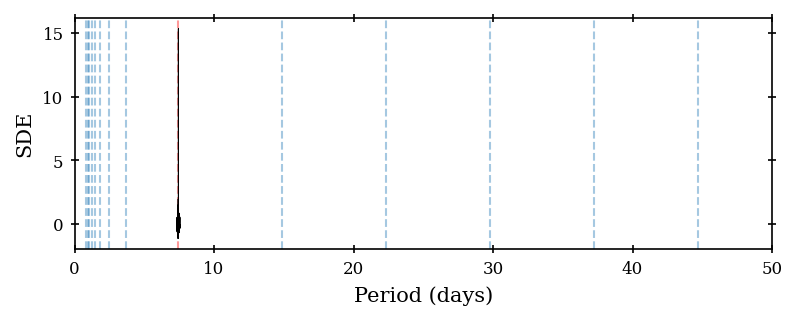

In [28]:
fig, ax = plt.subplots(figsize=(6,2), dpi=150)
plt.xlim(np.min(results.periods), np.max(results.periods))
ax.axvline(results.period, alpha=0.4, lw=1, linestyle="dashed", color='red')
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))
plt.xlim(0, 50)
#plt.ylim(0, 100)

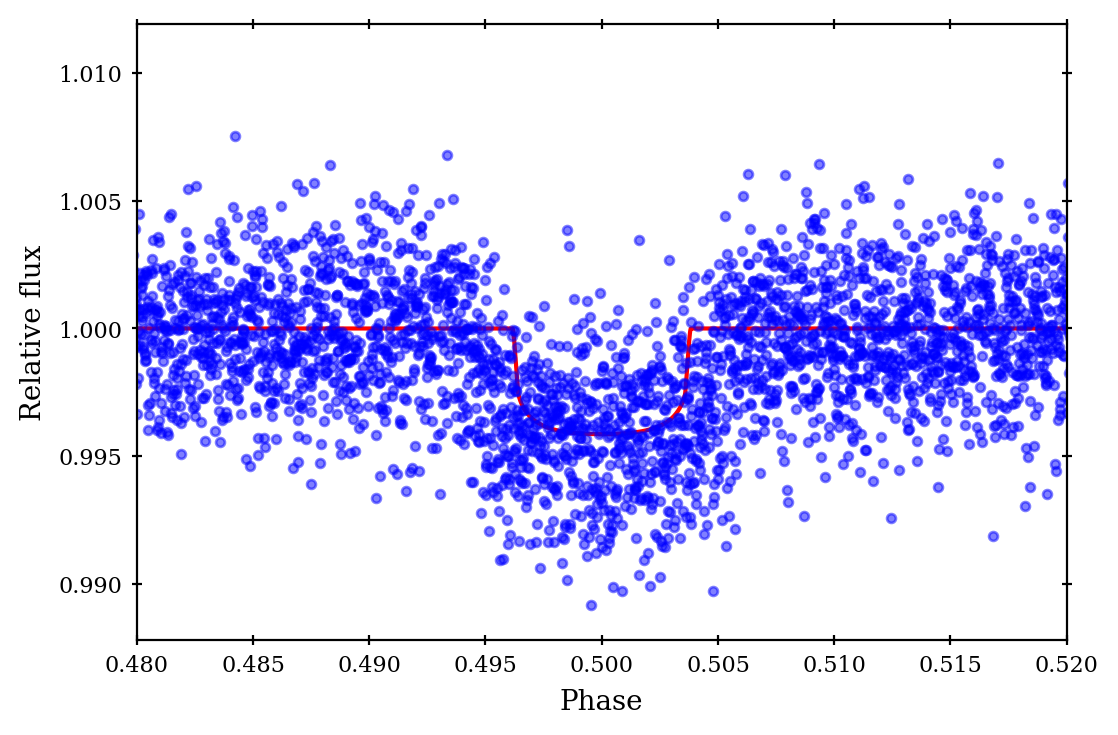

In [29]:
# results phase folded
plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

In [30]:
results.duration*10

0.07924848795517375

In [31]:
duration_tess/24

0.08347140734040416+/-0.006621239583333332

(2418.0, 2420.0)

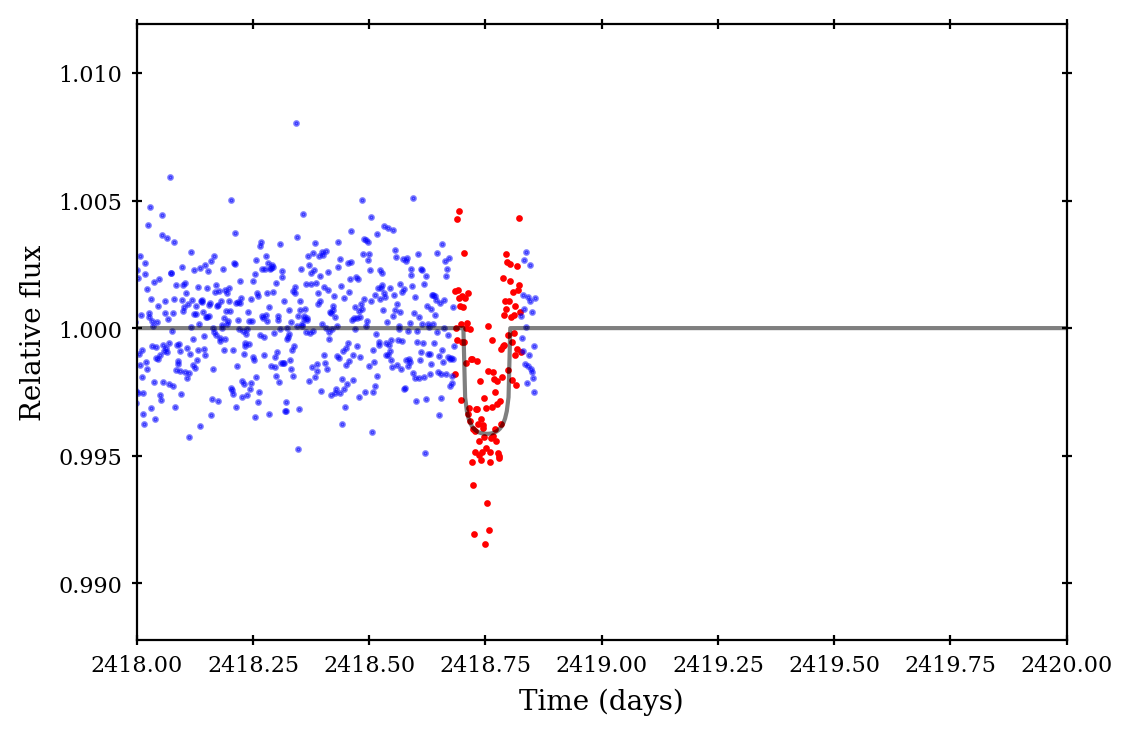

In [32]:
# complete light curve
plt.figure()
in_transit = transit_mask(tls_time, results.period, results.duration*18, results.T0)
plt.scatter(tls_time[in_transit], tls_flux[in_transit], color='red', s=2, zorder=0)
plt.scatter(tls_time[~in_transit], tls_flux[~in_transit], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results.model_lightcurve_time, results.model_lightcurve_model, alpha=0.5, color='k', zorder=1)
plt.xlim(tls_time.min(), tls_time.max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');
plt.xlim(2418,2420)

In [ ]:
# search for second planet
tls_time_2 = tls_time[~in_transit]
tls_flux_2 = tls_flux[~in_transit]
tls_flux_err_2 = tls_flux_err[~in_transit]

tls_2 = transitleastsquares(tls_time_2, tls_flux_2, tls_flux_err_2)
results2 = tls_2.power(R_star=float(info[4]), R_star_min=info[4]-info[5], R_star_max=info[4]+info[6],
                                                M_star=float(info[1]), M_star_min=info[1]-info[2], M_star_max=info[1]+info[3],
                                                period_min=0.5,
                                                period_max=(tls_time_2.max()-tls_time_2.min())/2,
                                                u=list(info[0]))

In [ ]:
print(results2.period, results2.T0, results2.duration, results2.depth, results2.SDE)

In [ ]:
fig, ax = plt.subplots(figsize=(6,2), dpi=150)
plt.xlim(np.min(results2.periods), np.max(results2.periods))
ax.axvline(results2.period, alpha=0.4, lw=1, linestyle="dashed", color='red')
for n in range(2, 10):
    ax.axvline(n*results2.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results2.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results2.periods, results2.power, color='black', lw=0.5)
#plt.xlim(0, max(results2.periods))
plt.xlim(0, 50)
plt.ylim(-1, 10)

In [ ]:
# results phase folded
plt.figure()
plt.plot(results2.model_folded_phase, results2.model_folded_model, color='red')
plt.scatter(results2.folded_phase, results2.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.48, 0.52)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

In [ ]:
# complete light curve
plt.figure()
in_transit2 = transit_mask(tls_time_2, results2.period, 1.5*results2.duration, results2.T0)
plt.scatter(tls_time_2[in_transit2], tls_flux_2[in_transit2], color='red', s=2, zorder=0)
plt.scatter(tls_time_2[~in_transit2], tls_flux_2[~in_transit2], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results2.model_lightcurve_time, results2.model_lightcurve_model, alpha=0.5, color='k', zorder=1)
plt.xlim(tls_time_2.min(), tls_time_2.max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');
plt.xlim(2750,2800)

### GLS analysis

Text(0.5, 1.0, 'GLS periodogram of TESS sectors (out of transit)')

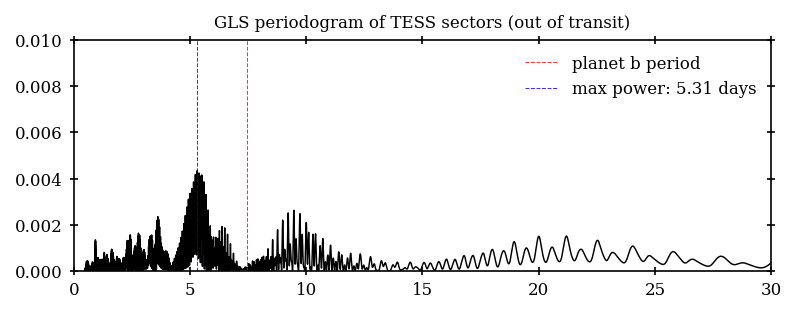

In [33]:
# first remove in-transit points
in_transit3 = transit_mask(time_short_all, results.period, 15*results.duration, results.T0)
lslc = ls(time_short_all[~in_transit3], flux_short_all[~in_transit3], flux_err_short_all[~in_transit3])

lc_freq, lc_power = lslc.autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=50)

# # plot the periodogram
fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=150)
ax.plot(1/lc_freq, lc_power, color='k', linewidth=0.7)
ax.set_xlim(0,30)
ax.set_ylim(0, 0.01)
ax.axvline(period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8, label='planet b period')
ax.axvline(1/lc_freq[np.argmax(lc_power)], color='b', linestyle='--', linewidth=0.5, alpha=0.8, 
           label='max power: '+str(np.round(1/lc_freq[np.argmax(lc_power)],2))+' days')
ax.legend(frameon=False, markerscale=0)
ax.set_title('GLS periodogram of TESS sectors (out of transit)')

(2735.0, 2750.0)

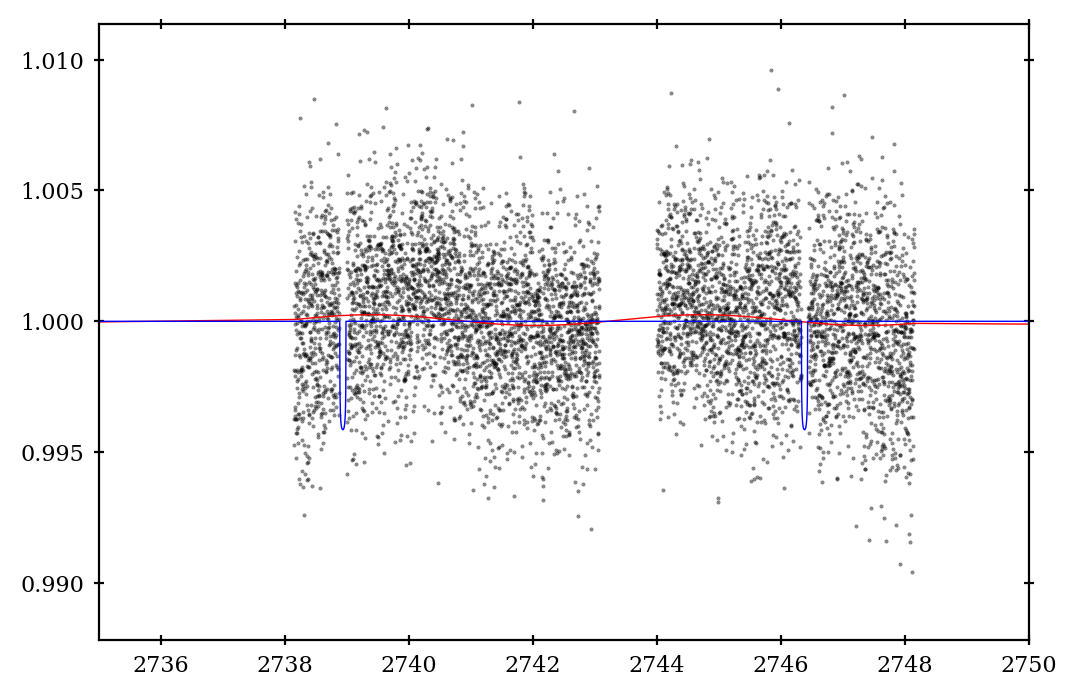

In [34]:
y_fit = lslc.model(time_short_all[~in_transit3], lc_freq[np.argmax(lc_power)])
plt.plot(time_short_all[~in_transit3], y_fit, color='r', linewidth=0.5)
plt.scatter(time_short_all[~in_transit3], flux_short_all[~in_transit3], color='k', s=0.2, alpha=0.5)
plt.plot(results.model_lightcurve_time, results.model_lightcurve_model, color='b', linewidth=0.5)
#plt.xlim(3452, 3477)
plt.xlim(2735, 2750)

In [35]:
# compare rms of residuals and rms of data
rms_data = np.std(flux_short_all[~in_transit3])
rms_res = np.std(flux_short_all[~in_transit3] - y_fit)
print(rms_data*1e3, rms_res*1e3)

2.2771850090688233 2.2717604426410962


In [36]:
# only one sector
mask = x<100
x = x[mask]
y = y[mask]
yerr = yerr[mask]

### LC model with GP

In [37]:
phase_lc = np.linspace(-0.3, 0.3, 100)

with pm.Model() as model:
    # Parameters for the stellar properties
    mean = pm.Normal("mean", mu=0.0, sigma=1.0)
    u_star = xo.QuadLimbDark("u_star")
    star = xo.LimbDarkLightCurve(u_star)

    # Stellar parameters from TESS
    mstar = pm.TruncatedNormal("mstar", mu=stmass_tess.n, sigma=stmass_tess.s, lower=0.0, upper=1.0)
    rstar = pm.TruncatedNormal("rstar", mu=strad_tess.n, sigma=strad_tess.s, lower=0.0, upper=1.0)

    # Orbital parameters for the planet
    t0 = pm.Normal("t0", mu=results.T0-ref_time, sigma=1.0)

    logP = pm.Normal("logP", mu=np.log(results.period), sigma=results.period_uncertainty/results.period)
    P = pm.Deterministic("P", pt.exp(logP))

    # Fit in terms of ror
    log_ror = pm.Normal("log_ror", mu=0.5*np.log((1-results.depth)), sigma=1)
    ror = pm.Deterministic("ror", pt.exp(log_ror))
    r_pl = pm.Deterministic("r_pl", ror * rstar)
    b = xo.ImpactParameter('b', ror)

    h, k = xo.unit_disk("h", "k", initval=np.array([0.01, 0.01]))
    ecc = pm.Deterministic("e", h**2 + k**2)
    omega = pm.Deterministic("w", pt.arctan2(k, h))

    # Transit jitter & GP parameters
    log_sigma_lc = pm.Normal("log_sigma_lc", mu=np.log(np.std(y)), sigma=10)
    log_rho_gp = pm.Normal("log_rho_gp", mu=0, sigma=10)
    log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.std(y)), sigma=10)


    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(
            r_star=rstar,
            m_star=mstar,
            period=P,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )
    
    # Compute the model light curve
    light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x, texp=texp_short)* 1e3)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # no gp
    # logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sigma=1.0)
    # err_lc = pm.math.sqrt(yerr**2 + pm.math.exp(2*logs))
    # transit_obs = pm.Normal("obs", mu=light_curve, sigma=err_lc, observed=y)

    # GP model for the light curve
    kernel = terms.SHOTerm(
            sigma=pt.exp(log_sigma_gp),
            rho=pt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),)
    
    gp = GaussianProcess(kernel, t=x, mean=light_curve, yerr=pt.exp(log_sigma_lc))
    gp.marginal("obs", observed=y)

    # Compute and save the phased light curve models
    pm.Deterministic("lc_pred", 1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp_short)[..., 0],)

    map_params = pm.find_MAP()
    map_soln = pmx.optimize(start=map_params)

    extras = dict(zip(["light_curves", "gp_pred"], pmx.eval_in_model([light_curves, gp.predict(y)], map_soln)))

Output()

Output()

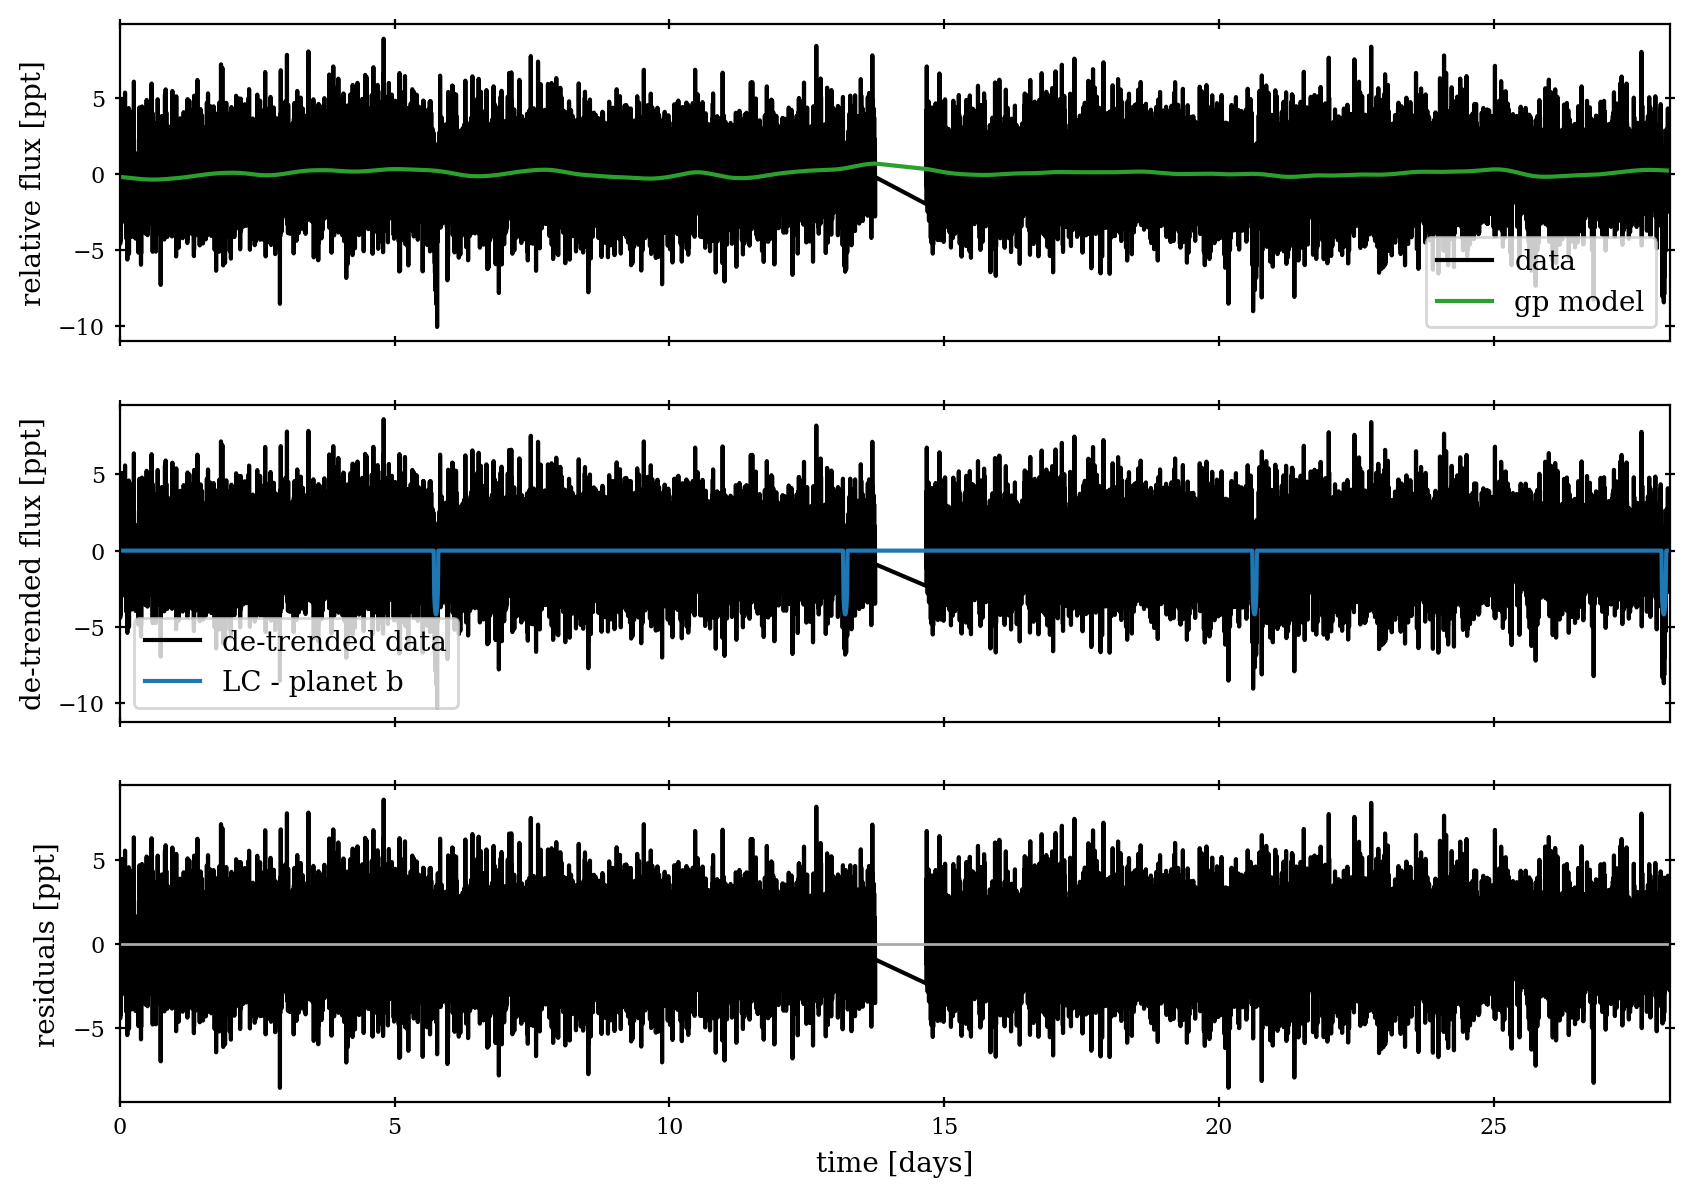

In [38]:
def plot_light_curve(soln, extras):

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
    for i, l in enumerate("b"):
        lc_mod = extras["light_curves"][:, i]
    gp_mod = extras["gp_pred"]
    gp_only = extras["gp_pred"] - soln["mean"] - lc_mod

    ax = axes[0]
    ax.plot(x, y, "k", label="data")
    ax.plot(x, gp_only, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x, y - gp_only, "k", label="de-trended data")
    for i, l in enumerate("b"):
        ax.plot(x, lc_mod, label="LC - planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    ax.plot(x, y - gp_mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x.min(), x.max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln, extras)
plt.savefig('toi4438_lc.png', dpi=300)

In [51]:
len(x)

19611

In [39]:
with model:
    trace = pm.sample(
        draws=200,
        tune=200,
        initvals=map_soln,
        chains=2,
        #cores=2,
        target_accept=0.95,
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/home/juan/anaconda3/envs/exoplanet2/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:627: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mean, __u_star_q1, __u_star_q2, mstar, rstar, t0, logP, log_ror, __b_impact_parameter, h, __k_unit_disk, log_sigma_lc, log_rho_gp, log_sigma_gp]


Output()

Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 1539 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [48]:
trace_summary = az.summary(trace, var_names=["mean", "u_star", "mstar", "rstar", "t0", "P", "ror", "b", "log_sigma_lc", "log_rho_gp", "log_sigma_gp"])

In [49]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,0.049,0.040,-0.021,0.115,0.002,0.001,485.0,368.0,1.00
u_star[0],0.452,0.292,0.003,0.952,0.018,0.014,281.0,325.0,1.00
u_star[1],0.181,0.339,-0.418,0.805,0.022,0.016,227.0,220.0,1.02
mstar,0.362,0.021,0.321,0.395,0.001,0.001,390.0,265.0,1.01
rstar,0.377,0.011,0.358,0.399,0.001,0.000,345.0,316.0,1.00
t0,5.755,0.001,5.753,5.757,0.000,0.000,359.0,272.0,1.00
P,7.446,0.000,7.445,7.447,0.000,0.000,456.0,232.0,1.00
ror,0.059,0.003,0.055,0.064,0.000,0.000,35.0,246.0,1.08
b,0.352,0.228,0.002,0.757,0.026,0.022,72.0,114.0,1.08
log_sigma_lc,0.756,0.005,0.747,0.766,0.000,0.000,772.0,392.0,1.00


In [ ]:
map_soln["t0"]

In [ ]:
plt.plot(phase_lc, map_soln["lc_pred"], color="C1", lw=1)
# add the phase folded light curve
plt.scatter((x-map_soln["t0"]) % map_soln["P"] - 0.5*map_soln["P"], y, c='k', s=2, alpha=0.5)


## Modelo Global

In [ ]:
# rvs: x_rv, y_rv, yerr_rv, rv_inst_id
# lc: x, y, yerr

# mismo punto de referencia en tiempo, donde empieza la curva de luz
x_rv -= ref_time

In [ ]:
# model
phase_lc = np.linspace(-0.15, 0.15, 500)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
with pm.Model() as model:
    mstar = pm.TruncatedNormal("mstar", mu=stmass_tess.n, sigma=stmass_tess.s, lower=0.0, upper=1.0)
    rstar = pm.TruncatedNormal("rstar", mu=strad_tess.n, sigma=strad_tess.s, lower=0.0, upper=1.0)
    P = pm.LogNormal("P", mu=np.log(period_tess.n), sigma=period_tess.s/period_tess.n)
    t0 = pm.Normal("t0", mu=epoch_tess.n, sigma=1)
    K = pm.Uniform("K", lower=0, upper=3*y_rv.std())

    # RV jitter & a quadratic RV trend
    sigma_rv = pm.LogNormal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  

    # Compute the RV offset and jitter for each data point depending on its instrument
    mean = tt.zeros(len(t))
    diag = tt.zeros(len(t))
    for i in range(len(rv_inst_names)):
        mean += means[i] * (inst_id == i)
        diag += (rv_err**2 + sigmas[i] ** 2) * (inst_id == i)
    pm.Deterministic("mean", mean)
    pm.Deterministic("diag", diag)
    resid = rv - mean
    

In [ ]:
strad_tess

In [ ]:
# model

# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t_rv = dict()
phase_lc = np.linspace(-0.15, 0.15, 500)

for k, data in enumerate(datasets):
    t_rv[k] = np.linspace(data['rjd'].min() - 5, data['rjd'].max() + 5, 3000)

    with pm.Model() as model[k]:
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
        mstar = BoundedNormal("mstar", mu=stmass_tess.n, sd=stmass_tess.s)
        rstar = BoundedNormal("rstar", mu=strad_tess.n, sd=strad_tess.s)

        logP = pm.Normal("logP", mu=np.log(bls_period), sd=period_tess.s/period_tess.n) #period_tess.s/period_tess.n
        P = pm.Deterministic("P", tt.exp(logP))
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)

        # logK = pm.Normal("logK", mu=np.log(Kest[k].item()), sd=2.0, testval=np.log(Kest[k].item()))
        # K = pm.Deterministic("K", tt.exp(logK))
        K = pm.Uniform("K", lower=0, upper=10)

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(data['svrad'])), sd=5.0)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Transit         
        log_ror = pm.Normal("log_ror", mu=0.5*np.log(bls_depth*1e-3), sd=1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        r_pl = pm.Deterministic("r_pl", ror * rstar)
        b = xo.ImpactParameter('b', ror)

        orbit = xo.orbits.KeplerianOrbit(period=P, 
                                        t0=t0, 
                                        r_star=rstar, 
                                        m_star=mstar,
                                        b=b)

        # derive mass, semimajor axis, and equilibrium temperature, and denisty
        m_pl = pm.Deterministic('m_pl', K*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
        a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))
        density_pl = pm.Deterministic('density_pl', m_pl*u.kg.to(u.g)/(4/3*np.pi*(r_pl*u.R_sun.to(u.cm))**3))
        teq = pm.Deterministic('teq', stteff_tess.n*(rstar*u.R_sun.to(u.au)/a)**(1/2)*(1/4)**(1/4))

        # The light curve model
        mean = pm.Normal("mean", mu=0.0, sd=5.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)
        logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=1)

        def lc_model(mean, star, r_pl, texp, t):
            return pm.Deterministic("lc_model_", tt.sum(1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t, texp=texp), axis=-1) + mean)
        
        lc_model_ = lc_model(mean, star, r_pl, texp, x)
        # The likelihood for the light curve
        err_lc = tt.sqrt(yerr**2 + tt.exp(2*logs)) 
        transit_obs = pm.Normal("lc_obs", mu=lc_model_, sd=err_lc, observed=y) 

        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred", tt.sum(star.get_light_curve(orbit=orbit, r=r_pl, t=t0+phase_lc, texp=texp)*1e3, axis=-1))

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=K)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref[k], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)

        # Define the RVs at the observed times
        rv_model = get_rv_model(data['rjd'])
        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t_rv[k], name="_pred")

        # Finally add in the RV observation model. 
        err = tt.sqrt(np.asarray(data['svrad'])**2  + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=data['vrad'])